In [ ]:
pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchviz import make_dot
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%matplotlib inline

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/'
dataset_path = os.path.join(root_dir,'Steganography/Dataset')

train_csv = os.path.join(root_dir,'train_dataset.csv')
valid_csv = os.path.join(root_dir,'validation_dataset.csv')
train_folder = os.path.join(dataset_path,'train')
validation_folder = os.path.join(dataset_path,'valid')

In [ ]:

IMG_SIZE = 64
LEARNING_RATE  = 0.001
COVER_LOSS_WEIGHT = 1
SECRET_LOSS_WEIGHT = 1
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 1
EPOCHS = 1000
DECODER_LOSS_WEIGHT = 1

In [ ]:
imagetransformation = {
    'train_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()]),
    'valid_transforms':torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),torchvision.transforms.ToTensor()])
}

In [ ]:
#conversion of image into resized format and return of trnasformed image
class SteganoDataset(torch.utils.data.Dataset):
    def __init__(self,dataset_csv,transforms,type_of_dataset,size='complete'):
        self.dataset = pd.read_csv(dataset_csv)
       
        self.dataset = self.dataset.reset_index(drop=True)
        if size !='complete':
            self.dataset = self.dataset[:2]
        self.transforms = transforms
        self.type = type_of_dataset
        if self.type == 'train':
           self.dataset = self.dataset.head(32)
        else:
          self.dataset = self.dataset.head(10)
    
    def __getitem__(self,index):
        cover_image = self.dataset.iloc[index]['cover_image']
        secret_image = self.dataset.iloc[index]['secret_image']
        cover_image = Image.open(os.path.join(dataset_path,self.type,cover_image))
        secret_image = Image.open(os.path.join(dataset_path,self.type,secret_image))
        transformed_cover_image = self.transforms(cover_image)
        transformed_secret_image = self.transforms(secret_image)

        if self.type == 'train':
            return {
                'cover_image':transformed_cover_image,
                'secret_image':transformed_secret_image,
            }
        else:
            return {
                'cover_image':transformed_cover_image,
                'secret_image':transformed_secret_image,
            }
    
    def __len__(self):
      return len(self.dataset)

In [ ]:

from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})
A = imread('/content/drive/MyDrive/Colab Notebooks/lena.jpeg')
B = np.mean(A, -1); # Convert RGB to grayscale



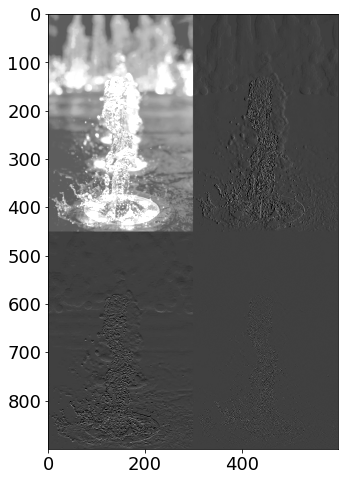

In [ ]:
## Wavelet Compression
n = 1
w = 'db1'
coeffs = pywt.wavedec2(B,wavelet=w,level=n)

# normalize each coefficient array
coeffs[0] /= np.abs(coeffs[0]).max()
for detail_level in range(n):
    coeffs[detail_level + 1] = [d/np.abs(d).max() for d in coeffs[detail_level + 1]]

arr, coeff_slices = pywt.coeffs_to_array(coeffs)



plt.imshow(arr,cmap='gray',vmin=-0.25,vmax=0.75)
plt.show()

In [ ]:
pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PrepNetwork1(nn.Module):
    def __init__(self):
        super(PrepNetwork1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
    
    def forward(self,secret_image):
        output_1 = F.relu(self.conv1(secret_image))
        output_2 = F.relu(self.conv2(secret_image))
        output_3 = F.relu(self.conv3(secret_image))
        
        concatenated_image = torch.cat([output_1,output_2,output_3],dim=1)
        output_4 = F.relu(self.conv4(concatenated_image))
        output_5 = F.relu(self.conv5(concatenated_image))
        output_6 = F.relu(self.conv6(concatenated_image))
        
        final_concat_image = torch.cat([output_4,output_5,output_6],dim=1)
        return final_concat_image

class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=68,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=68,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=68,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)
        
    def forward(self,secret_image_1,cover_image):
        concatenated_secrets = torch.cat([cover_image,secret_image_1],dim=1)
        
        output_1 = F.relu(self.conv1(concatenated_secrets))
        output_2 = F.relu(self.conv2(concatenated_secrets))
        output_3 = F.relu(self.conv3(concatenated_secrets))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_converted_image = F.relu(self.final_layer(concat_5))
        
        return output_converted_image

In [ ]:
class Encoder(nn.Module):
    def __init__(self,prep_network_1,hiding_network):
        super(Encoder, self).__init__()
        self.prep_network1 = prep_network_1
        self.hiding_network = hiding_network
    
    def forward(self,cover_image,secret_image_1):
        encoded_secret_image_1 = self.prep_network1(secret_image_1)
        
        hidden_image = self.hiding_network(encoded_secret_image_1,
                                           cover_image
                                          )
#         hidden_image = (0.01**0.5)*torch.randn(hidden_image.size(),device=device)
        return hidden_image

In [ ]:
class RevealNetwork1(nn.Module):
    def __init__(self):
        super(RevealNetwork1,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv4 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv5 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv6 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv7 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv8 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv9 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv10 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv11 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv12 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.conv13 = nn.Conv2d(in_channels=65,out_channels=50,kernel_size=(3,3),stride=1,padding=1)
        self.conv14 = nn.Conv2d(in_channels=65,out_channels=10,kernel_size=(3,3),stride=1,padding=1)
        self.conv15 = nn.Conv2d(in_channels=65,out_channels=5,kernel_size=(5,5),stride=1,padding=2)
        
        self.final_layer = nn.Conv2d(in_channels=65,out_channels=3,kernel_size=(3,3),stride=1,padding=1)    
    
    def forward(self,hidden_image):
        
        output_1 = F.relu(self.conv1(hidden_image))
        output_2 = F.relu(self.conv2(hidden_image))
        output_3 = F.relu(self.conv3(hidden_image))
        concat_1 = torch.cat([output_1,output_2,output_3],dim=1)
        
        output_4 = F.relu(self.conv4(concat_1))
        output_5 = F.relu(self.conv5(concat_1))
        output_6 = F.relu(self.conv6(concat_1))
        concat_2 = torch.cat([output_4,output_5,output_6],dim=1)
        
        output_7 = F.relu(self.conv7(concat_2))
        output_8 = F.relu(self.conv8(concat_2))
        output_9 = F.relu(self.conv9(concat_2))
        concat_3 = torch.cat([output_7,output_8,output_9],dim=1)
        
        output_10 = F.relu(self.conv10(concat_3))
        output_11 = F.relu(self.conv11(concat_3))
        output_12 = F.relu(self.conv12(concat_3))
        concat_4 = torch.cat([output_10,output_11,output_12],dim=1)
        
        output_13 = F.relu(self.conv13(concat_4))
        output_14 = F.relu(self.conv14(concat_4))
        output_15 = F.relu(self.conv15(concat_4))
        concat_5 = torch.cat([output_13,output_14,output_15],dim=1)
        
        output_revealed_image = F.relu(self.final_layer(concat_5))
        
        return output_revealed_image

In [ ]:
class Decoder(nn.Module):
    def __init__(self,reveal_network_1):
        super(Decoder, self).__init__()
        self.reveal_network_1 = reveal_network_1
    
    def forward(self,hidden_image):
        reveal_image_1 = self.reveal_network_1(hidden_image)
        return reveal_image_1

In [ ]:
class SteganoModel(nn.Module):
    def __init__(self,encoder,decoder):
        super(SteganoModel,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self,cover_image,secret_image_1,hidden_image,mode):
        if mode == 'full':
            for param in self.encoder.parameters():
                param.requires_grad = True
            for param in self.decoder.parameters():
                param.requires_grad = False
            hidden_image = self.encoder(cover_image,secret_image_1)
            reveal_image_1 = self.decoder(hidden_image)
            return hidden_image,reveal_image_1
        elif mode == 'encoder':
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False
            hidden_image = self.encoder(cover_image,secret_image_1)
            return hidden_image
        elif mode == 'decoder':
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = True
            
            reveal_image1 = self.decoder(hidden_image)
            return reveal_image1

In [ ]:
prep_1 = PrepNetwork1()
hiding_network = HidingNetwork()

encoder = Encoder(prep_1,hiding_network)

reveal_1 = RevealNetwork1()


decoder = Decoder(reveal_1)

model = SteganoModel(encoder,decoder)
model.to(device)

SteganoModel(
  (encoder): Encoder(
    (prep_network1): PrepNetwork1(
      (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(65, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv6): Conv2d(65, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (hiding_network): HidingNetwork(
      (conv1): Conv2d(68, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(68, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(68, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv4): Conv2d(65, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv5): Conv2d(65, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
class SteganoLoss(nn.Module):
    def __init__(self,cover_weight,secret_weight):
        super(SteganoLoss,self).__init__()
        self.cover_weight = cover_weight
        self.secret_weight = secret_weight
        
    def forward(self,predicted_cover_image,cover_image,
               predicted_secret_image_1,secret_image_1):
    
        cover_loss = self.cover_weight*(F.mse_loss(predicted_cover_image,cover_image))
        secret_loss = self.secret_weight*(F.mse_loss(predicted_secret_image_1,secret_image_1)) 
        return cover_loss + secret_loss

class DecoderLoss(nn.Module):
    def __init__(self,decoder_loss_weight):
        super(DecoderLoss,self).__init__()
        self.decoder_loss_weight = decoder_loss_weight
    
    def forward(self,reveal_output1,secret_image_1):
        reveal1 = self.decoder_loss_weight*F.mse_loss(reveal_output1,secret_image_1)
        return reveal1

In [ ]:
training_csv_path = os.path.join(dataset_path,train_csv)
validation_csv_path = os.path.join(dataset_path,valid_csv)

training_dataset = SteganoDataset(training_csv_path,imagetransformation['train_transforms'],'train','complete')
valid_dataset = SteganoDataset(validation_csv_path,imagetransformation['valid_transforms'],'valid')

train_data_loader = torch.utils.data.DataLoader(training_dataset, 
                                                batch_size = TRAIN_BATCH_SIZE, 
                                                shuffle=True,
                                               drop_last = True,
                                               num_workers = 0
                                               )
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, 
                                                batch_size = VALID_BATCH_SIZE, 
                                                shuffle=True,
                                                drop_last = True,
                                                num_workers = 0
                                               )

full_model_criterion = SteganoLoss(SECRET_LOSS_WEIGHT,COVER_LOSS_WEIGHT)

full_model_optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

decoder_criterion = DecoderLoss(DECODER_LOSS_WEIGHT)

In [ ]:
def train(model,epochs,decoder_criterion,full_model_optimizer,full_model_criterion,learning_rate,training_iterator,valid_iterator,print_every=1):
    
    training_full_model_loss_list = []
    decoder_loss_list = []
    valid_loss_list = []
    
    for epoch in range(1000):
        for index,training_dict in enumerate(training_iterator):

            cover_image = training_dict['cover_image']
            cover_image = cover_image.to(device)

            secret_image_1 = training_dict['secret_image']
            secret_image_1 = secret_image_1.to(device)

            
            full_model_optimizer.zero_grad()

            encoder_output = model(cover_image,secret_image_1,secret_image_1,'encoder')

            hidden_image,reveal_image_1 = model(cover_image,secret_image_1,secret_image_1,
                                                                'full')

            full_model_loss = full_model_criterion(hidden_image,cover_image,
                             reveal_image_1,secret_image_1
                            )
            full_model_loss.backward()
            full_model_optimizer.step()

            full_model_optimizer.zero_grad()
            reveal_output1 = model(cover_image,secret_image_1,
                                                                 encoder_output,'decoder')
            decoder_loss = decoder_criterion(reveal_output1,secret_image_1)

            decoder_loss.backward()
            full_model_optimizer.step()
        training_full_model_loss_list.append(full_model_loss)
        decoder_loss_list.append(decoder_loss)
        if epoch % print_every == 0:
            print("Training full model loss at {} epochs is: {}".format(epoch, full_model_loss))
            print("Training decoder loss at {} epochs is: {}".format(epoch, decoder_loss))

    return model, training_full_model_loss_list,decoder_loss_list

In [ ]:
model, training_full_model_loss_list,decoder_loss_list = train(model,EPOCHS,decoder_criterion,full_model_optimizer,full_model_criterion,LEARNING_RATE,train_data_loader,valid_data_loader)

Training full model loss at 0 epochs is: 0.1738722324371338
Training decoder loss at 0 epochs is: 0.13445276021957397
Training full model loss at 1 epochs is: 0.17344681918621063
Training decoder loss at 1 epochs is: 0.1384771764278412
Training full model loss at 2 epochs is: 0.16090291738510132
Training decoder loss at 2 epochs is: 0.13042621314525604
Training full model loss at 3 epochs is: 0.1441342979669571
Training decoder loss at 3 epochs is: 0.11604117602109909
Training full model loss at 4 epochs is: 0.15392404794692993
Training decoder loss at 4 epochs is: 0.12957976758480072
Training full model loss at 5 epochs is: 0.1523105949163437
Training decoder loss at 5 epochs is: 0.12873858213424683
Training full model loss at 6 epochs is: 0.14733514189720154
Training decoder loss at 6 epochs is: 0.1223788782954216
Training full model loss at 7 epochs is: 0.1410852074623108
Training decoder loss at 7 epochs is: 0.1150331199169159
Training full model loss at 8 epochs is: 0.139200508594

In [ ]:
data = next(iter(valid_data_loader))

cover_image = data['cover_image']
cover_image = cover_image.to(device)

secret_image_1 = data['secret_image']
secret_image_1 = secret_image_1.to(device)

model.eval()
    
hidden_image,reveal_image_1 = model(cover_image,secret_image_1,secret_image_1,'full')

In [ ]:
make_dot(hidden_image).render('hidden_image',format='png')

'hidden_image.png'

In [ ]:
make_dot(reveal_image_1).render('reveal_image',format='png')

'reveal_image.png'

In [ ]:
def plot_loss(loss_list):
    with torch.no_grad():
      plt.plot(torch.tensor(loss_list, device = 'cpu'))
      plt.show()

In [ ]:
training_full_model_loss_list

[tensor(0.4151, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2812, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.3007, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.3429, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2654, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.3342, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2375, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2470, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2042, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1964, device='cuda:0', grad_fn=<AddBackward0>)]

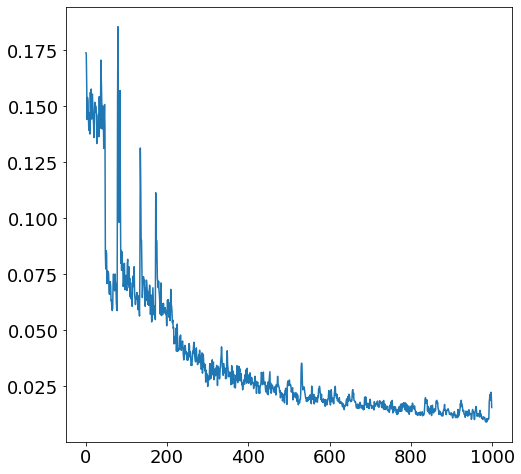

In [ ]:
plot_loss(training_full_model_loss_list)

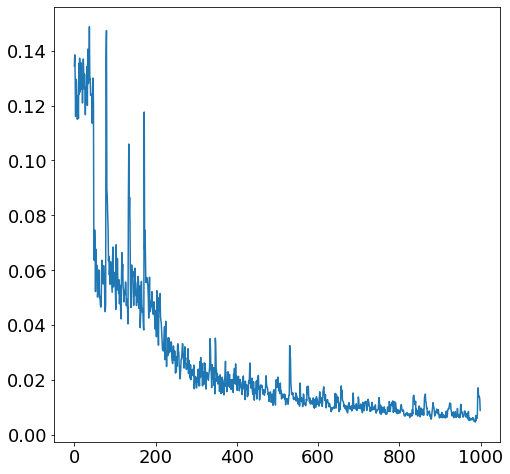

In [ ]:
plot_loss(decoder_loss_list)

In [ ]:
def predict(model,iterator):
    predict_dict = next(iter(iterator))
    cover_image = predict_dict['cover_image']
    cover_image = cover_image.to(device)

    secret_image_1 = predict_dict['secret_image']
    secret_image_1 = secret_image_1.to(device)

    
    model.eval()
    
    hidden_image,reveal_image_1= model(cover_image,secret_image_1,secret_image_1,
                                                                 'full')
    
    cover_image = cover_image * 255
    secret_image_1 = secret_image_1 * 255

    
    hidden_image = hidden_image * 255
    reveal_image_1 = reveal_image_1 * 255

    
    secret_image_1 = secret_image_1.to(torch.device('cpu'))
    cover_image = cover_image.to(torch.device('cpu'))
    
    reveal_image_1 = reveal_image_1.to(torch.device('cpu'))
    hidden_image = hidden_image.to(torch.device('cpu'))
    
    secret_image_1 = secret_image_1.detach().to(torch.long)

    cover_image = cover_image.detach().to(torch.long)

    hidden_image = hidden_image.detach().to(torch.long)
    reveal_image_1 = reveal_image_1.detach().to(torch.long)

    
    
    hidden_image_grid = torchvision.utils.make_grid(hidden_image,nrow=4)
    reveal_image_1_grid = torchvision.utils.make_grid(reveal_image_1,nrow=4)

    
    cover_image_grid = torchvision.utils.make_grid(cover_image,nrow=4)
    secret_image_1_grid = torchvision.utils.make_grid(secret_image_1,nrow=4)

    return {
        'cover_image_grid':cover_image_grid,
        'secret_image_1_grid':secret_image_1_grid,
        'hidden_image_grid':hidden_image_grid,
        'reveal_image_1_grid':reveal_image_1_grid,
    }

In [ ]:
grids = predict(model,valid_data_loader)

In [ ]:
def plot(grids):
    plt.figure(figsize=(15,8))
    
    plt.subplot(241)
    plt.title('Cover Image')
    plt.imshow(grids['cover_image_grid'].permute(1,2,0))

    plt.subplot(242)
    plt.title('Secret Image 1')
    plt.imshow(grids['secret_image_1_grid'].permute(1,2,0))

    plt.subplot(245)
    plt.title('Hidden Image')
    plt.imshow(grids['hidden_image_grid'].permute(1,2,0))

    plt.subplot(246)
    plt.title('Reveal Image 1')
    plt.imshow(grids['reveal_image_1_grid'].permute(1,2,0))


    plt.show()

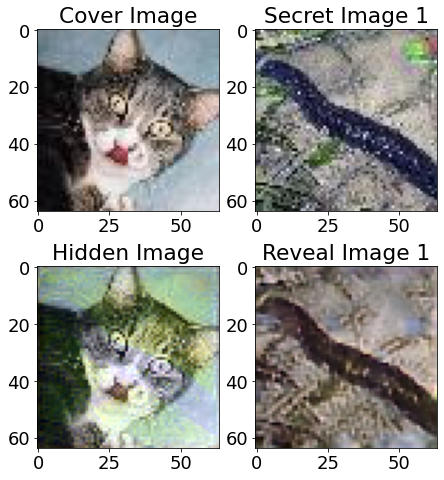

In [ ]:
plot(grids)

In [ ]:
for i in range(5):
    grids = predict(model,valid_data_loader)
    plot(grids)